In [234]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sn
import matplotlib.pyplot as plt

In [215]:
def read_data(filepath):
    data = pd.read_excel(filepath, sheet_name = "Data", headers = None)
    data.rename(columns=data.iloc[0], inplace = True)
    data = data[1:]
    data.rename(columns={ data.columns[1]: "tic" }, inplace = True)
    data.rename(columns={ data.columns[0]: "id" }, inplace = True)
    data = data.set_index('tic')


    inter = pd.read_excel(filepath, sheet_name = "Int", headers = None)
    inter.rename(columns=inter.iloc[1], inplace = True)
    inter = inter[2:]
    inter.rename(columns={ inter.columns[1]: "tic" }, inplace = True)
    inter = inter.set_index('tic')
    inter.rename(columns={ inter.columns[0]: "id" }, inplace = True)
    inter['id'] = inter.id.astype(int)
    
    final = pd.read_excel(filepath, sheet_name = "Fnl", headers = None)
    final.columns = ['id', 'tic', 'MktCap', 'Shares', 'AvgV', 'r182', 'r364']
    final = final[3:]
    final['id'] = final.id.astype(int)
    final = final.set_index('tic')
    return data, inter, final

In [216]:
filepath = "../TestData.1.xlsx"

data, inter, final = read_data(filepath)


## Independent Variables

In [217]:
data

,id,S t+1,S t,St-1,St-2,St-3,St-4,St-5,GPt-1,GPt-2,...,PREFt-5,TEQt-1,TEQt-2,TEQt-3,TEQt-4,TEQt-5,VarT,VarT+1,Srpr1,Srpr4
tic,,,,,,,,,,,,,,,,,,,,,
A,1,5620000,5200000,5160000,4910000,4470000,4200000,4040000,2790000,2680000,...,NaN,4750000,4570000,4830000,4240000,4170000,0.048,0.046,0.164,0.067
AA,2,9470000,8780000,10500000,13520000,11780000,9330000,11220000,1200000,2690000,...,0,4110000,5620000,4520000,5650000,9440000,0.131,0.213,0.042,0.056
AAL,3,29770000,17460000,45770000,44540000,42620000,40180000,40990000,11420000,11020000,...,NaN,-118000,-169000,-780000,3790000,5640000,0.32,0.514,-0.016,-0.031
AAN,4,4450000,4120000,3950000,3830000,3380000,3210000,3180000,1730000,1810000,...,NaN,1740000,1760000,1730000,1480000,1370000,0.019,0.085,0.513,0.142
AAOI,5,259990,219910,190870,267470,382330,260710,189900,45700,87270,...,0,273790,329090,333280,227380,165400,0.153,0.191,-0.158,0.183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNTL,1521,NaN,NaN,NaN,14,NaN,NaN,NaN,-111,NaN,...,NaN,-80110,24770,NaN,NaN,NaN,NaN,NaN,-0.56,NaN
ZSAN,1522,39040,2640,NaN,NaN,NaN,NaN,313,-1520,-764,...,NaN,9390,18710,7050,4490,26500,NaN,0.681,0,0.034
ZTS,1523,6760000,6180000,6260000,5830000,5310000,4890000,4770000,4110000,3800000,...,NaN,2710000,2190000,1770000,1490000,1070000,0.065,0.089,0.105,0.079


## Intermediate Variables - percentage change, ratio

In [218]:
inter


,id,Margin_GM,Margin_EBITM,Margin_PBTM,Margin_EBITDAM,Margin_NM,Margin_OCFM,Growth_GM,Growth_EBITM,Growth_PBTM,Growth_EBITDAM,Growth_NM,Growth_OCFM,Projections_St+1,Projections_St,Projections_SGrt+1
tic,,,,,,,,,,,,,,,,
A,1,0.540698,0.179264,0.178101,0.226744,0.207364,0.197674,0.0410448,-463.5,-0.0285412,0.0446429,2.38608,-0.0642202,5620000,5200000,0.0807692
AA,2,0.114286,0.029619,-0.0417143,0.153333,-0.107619,0.0653333,-0.553903,-1.61952,-1.26871,-0.488889,-5.52,0.53125,9470000,8780000,0.0785877
AAL,3,0.249508,0.066856,0.0493773,0.131527,0.0369237,0.0834608,0.0362976,0.204724,0.202128,0.0730838,0.198582,0.082153,29770000,17460000,0.70504
AAN,4,0.437975,0.0254608,0.0234911,0.105889,0.00796709,0.11179,-0.0441989,-0.623742,-0.632078,0.092776,-0.839611,0.238626,4450000,4120000,0.0800971
AAOI,5,0.23943,0,-0.269241,-0.129565,-0.346047,0,-0.476338,NaN,4.2546,-2.30639,29.7209,-1,259990,219910,0.182256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNTL,1521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.97866,0.969237,1.16706,0.614021,NaN,NaN,NaN
ZSAN,1522,NaN,NaN,NaN,NaN,NaN,NaN,0.989529,-1,0.0630656,0.0460411,0.0630656,0.162431,39040,2640,13.7879
ZTS,1523,0.65655,0.317891,0.28754,0.388179,0.239617,0.28754,0.0815789,0.0874317,0.0650888,0.109589,0.048951,0.00558659,6760000,6180000,0.0938511


## Dependent Variables

In [219]:
final

,id,MktCap,Shares,AvgV,r182,r364
tic,,,,,,
AIN,1,1551.31,30719,202.314,0.110134,-0.426267
AIR,2,657.695,35303,273.594,-0.156632,-0.591268
AJRD,3,3200.67,78621,536.351,0.0682236,-0.197674
ATRO,4,254.183,23586,231.025,-0.361669,-0.723005
AVAV,5,1663.24,24105,151.204,0.476884,0.119585
...,...,...,...,...,...,...
VLRS,1636,735.32,877856,361.847,0.455696,-0.234791
WERN,1637,3217.85,69097,946.548,0.559612,0.329432
XPO,1638,7996.47,91326,1398.82,0.577089,0.168713


## Find Correlation btw Intermediate Variables and Final Values

In [220]:
input_variables = inter.columns.to_list()[1:]

In [228]:
output_var = 'r364'
analysis = pd.DataFrame()

# dropping duplicates from final data
final = final[~final.index.duplicated(keep='first')]

inter_tics = list(set(inter.index.tolist()))
final_tics = list(set(final.index.tolist()))

print('Total unique companies : ', len(final_tics))
print('Output variable in consideration: ', output_var)

analysis['output'] = final.loc[final_tics][output_var]

for inter_var in input_variables:
    print("Input variable, ", inter_var)
    analysis[inter_var] = inter.loc[final_tics][inter_var]
    analysis = analysis.dropna()
    print("Companies with valid intermediate, final variables: ", analysis.shape[0])
    corr_spearman, _ = stats.spearmanr(analysis['output'], analysis[inter_var])
    corr_pearson, _ = stats.pearsonr(analysis['output'], analysis[inter_var])
    print("Spearman correlation {}, Pearson correlation {}".format(corr_spearman, corr_pearson))
    print()


Total unique companies :  1525
Output variable in consideration:  r364
Input variable,  Margin_GM
Companies with valid intermediate, final variables:  1269
Spearman correlation -0.016597938421665383, Pearson correlation -0.04722092187539192

Input variable,  Margin_EBITM
Companies with valid intermediate, final variables:  1269
Spearman correlation -0.04448296262541662, Pearson correlation -0.07939669986860269

Input variable,  Margin_PBTM
Companies with valid intermediate, final variables:  1269
Spearman correlation -0.0003436850909252519, Pearson correlation -0.06629944659441875

Input variable,  Margin_EBITDAM
Companies with valid intermediate, final variables:  1269
Spearman correlation -0.06839557259828156, Pearson correlation -0.052830734457275874

Input variable,  Margin_NM
Companies with valid intermediate, final variables:  1269
Spearman correlation 0.0003962617079822369, Pearson correlation -0.06734981073563076

Input variable,  Margin_OCFM
Companies with valid intermediate, 

## Sample Analysis

In [229]:
analysis

,output,Margin_GM,Margin_EBITM,Margin_PBTM,Margin_EBITDAM,Margin_NM,Margin_OCFM,Growth_GM,Growth_EBITM,Growth_PBTM,Growth_EBITDAM,Growth_NM,Growth_OCFM,Projections_St+1,Projections_St,Projections_SGrt+1
tic,,,,,,,,,,,,,,,,
VNCE,-0.538729,0.450305,-0.0543458,0.0812655,0.0345692,0.0810256,0.0448306,0.0674796,11.1369,-17.9389,-0.286579,-16.5102,5.41985,308900,261500,0.181262
FRO,-0.100917,0.214207,-0.386247,0.164695,0.327678,0.306253,0.234977,5.18315,-9.47717,-0.197395,1.88324,0.303841,2.04189,708020,1120000,-0.367839
FBM,-0.148568,0.267986,0.0408558,0.0255628,0.0926977,0.0194558,0.080307,0.12327,7.57812,-2.30702,0.36666,-2.14854,1.49365,2150000,2060000,0.0436893
DIOD,0.179412,0.358216,0.138568,0.1586,0.229088,0.1226,0.183816,0.0739693,0.157125,0.322019,0.102572,0.473274,0.238185,1240000,1160000,0.0689655
CALM,-0.149494,0.135193,0.001,0.0148593,0.0476815,0.0136222,0.0597926,-0.181055,-0.97053,-0.716707,-0.373284,-0.660889,-0.298636,1500000,1420000,0.056338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DNKN,-0.057733,0.490197,0.305978,0.233036,0.346912,0.176657,0.217321,0.0379111,0.0509703,0.103942,0.0673509,0.0526728,0.106968,1360000,1260000,0.0793651
STKL,1.90871,0.0872405,-0.00617089,0.0021962,0.0277532,-0.000639241,0.00824051,-0.0583413,-0.903931,-1.02338,-0.0563805,-0.992865,-1.90166,1300000,1250000,0.04
FNV,0.636769,0.516661,0.484911,0.480884,0.794357,0.40767,0.731804,0.55395,1.22054,1.19743,0.339577,1.53436,0.331828,707170,681670,0.0374081


## Correlation Matrix

In [262]:
analysis = analysis.astype(np.float16)
corrMatrix = analysis.corr()

corrMatrix

,output,Margin_GM,Margin_EBITM,Margin_PBTM,Margin_EBITDAM,Margin_NM,Margin_OCFM,Growth_GM,Growth_EBITM,Growth_PBTM,Growth_EBITDAM,Growth_NM,Growth_OCFM,Projections_St+1,Projections_St,Projections_SGrt+1
output,1.000000,0.018199,0.020028,-0.093796,-0.095261,-0.093449,-0.095943,0.048212,0.006498,-0.024370,0.017472,-0.018488,0.005735,-0.084409,0.215985,0.052776
Margin_GM,0.018199,1.000000,0.095592,0.134511,0.136153,0.134297,0.167569,-0.017750,0.002864,-0.010534,-0.033281,0.007709,-0.008022,0.363792,0.351447,-0.101079
Margin_EBITM,0.020028,0.095592,1.000000,0.107551,0.066243,0.107073,0.075307,0.017337,0.005875,-0.004789,-0.014078,-0.020768,0.004188,-0.060301,0.222379,-0.384591
Margin_PBTM,-0.093796,0.134511,0.107551,1.000000,0.998635,0.999995,0.997816,0.001222,-0.000717,-0.003227,-0.026866,-0.012758,0.001677,0.220130,0.360718,-0.119200
Margin_EBITDAM,-0.095261,0.136153,0.066243,0.998635,1.000000,0.998640,0.999199,0.001269,-0.000516,-0.002995,-0.026683,-0.011891,0.001639,0.218691,0.374341,-0.106757
Margin_NM,-0.093449,0.134297,0.107073,0.999995,0.998640,1.000000,0.997807,0.000867,-0.000718,-0.003321,-0.026833,-0.012863,0.001684,0.220398,0.363753,-0.118313
Margin_OCFM,-0.095943,0.167569,0.075307,0.997816,0.999199,0.997807,1.000000,0.002349,-0.000333,-0.003080,-0.027169,-0.012220,0.001697,0.205453,0.380559,-0.119922
Growth_GM,0.048212,-0.017750,0.017337,0.001222,0.001269,0.000867,0.002349,1.000000,-0.001353,-0.002368,-0.029187,-0.007018,-0.001791,0.252960,-0.126001,-0.055831
Growth_EBITM,0.006498,0.002864,0.005875,-0.000717,-0.000516,-0.000718,-0.000333,-0.001353,1.000000,-0.002556,-0.007404,-0.006428,0.001051,-0.261665,0.089829,0.005800
Growth_PBTM,-0.024370,-0.010534,-0.004789,-0.003227,-0.002995,-0.003321,-0.003080,-0.002368,-0.002556,1.000000,0.010311,0.031479,-0.000735,0.101173,-0.182795,0.003008


## Plotting Heatmap

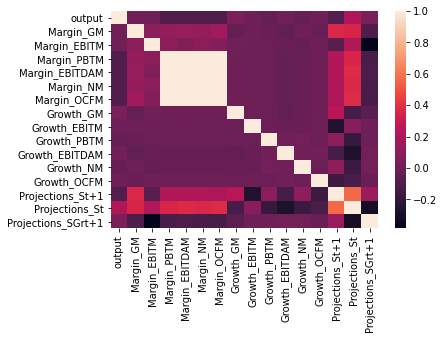

In [263]:
sn.heatmap(corrMatrix, xticklabels=corrMatrix.columns,
        yticklabels=corrMatrix.columns)
plt.show()